In [172]:
from pathlib import Path
import random
random.seed(42)

dataset = 'DWUG-Swedish'
path_ = f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/tokenization/LSC/{dataset}/corpus2/token/"

for p in Path(path_).glob('*.txt'):
    target = str(p).split('/')[-1].replace('.txt', '')
    rows = open(p, encoding='utf-8', mode='r').readlines()
    
    random.shuffle(rows)
    n = len(rows)//2
    
    p1 = str(p).replace(f'{dataset}/corpus2/', f'{dataset}-repl/corpus1/')
    p2 = str(p).replace(f'{dataset}/corpus2/', f'{dataset}-repl/corpus2/')
    
    Path(p1.replace(f'{target}.txt', '')).mkdir(exist_ok=True, parents=True)
    Path(p2.replace(f'{target}.txt', '')).mkdir(exist_ok=True, parents=True)    
    
    p1_sent = rows[:n]
    p1_sent = [json.dumps(json.loads(r))+'\n' for r in p1_sent]
    p2_sent = rows[n:]
    p2_sent = [json.dumps(json.loads(r))+'\n' for r in p2_sent]
    
    open(p1, mode='w', encoding='utf-8').writelines(p1_sent)   
    open(p2, mode='w', encoding='utf-8').writelines(p2_sent)

In [173]:
import json 
import numpy as np

path_ = f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/tokenization/LSC/{dataset}-repl/corpus1/token/"

paths = list(Path(path_).glob('*.txt'))
change = np.linspace(0, 1, len(paths))

random.shuffle(change)

truth_path = f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/datasets/LSC/{dataset}/truth/graded.txt"
open(truth_path, mode='w', encoding='utf-8').writelines([str(grade)+'\n' for grade in change])

targets = list()

for i, p in enumerate(paths):
    target = str(p).split('/')[-1].replace('.txt', '')
    targets.append(target)
    new_sentences = list()
    for p1 in Path(path_).glob('*.txt'):
        target1 = str(p1).split('/')[-1].replace('.txt', '')
        if target1 == target: continue
        tmp = list()
        for r in open(p1, mode='r', encoding='utf-8').readlines():
            try:
                tmp.append(json.loads(r))
            except:
                print(r)
        for r in tmp:
            delta = len(target) - len(r['token'])
            r['end']+=delta
            r['token'] = target
            r['lemma'] = target
            r['sentence'] = r['sentence'][:r['start']] + r['token'] + ' '+ r['sentence'][r['end']:]
            
        new_sentences.extend([json.dumps(r)+'\n' for r in tmp])
        
    p = str(p).replace(f'{dataset}-repl/corpus1/', f'{dataset}-repl/corpus2/')
    old_sentences = open(p, mode='r', encoding='utf-8').readlines()
    
    random.shuffle(new_sentences)
    new_sentences = new_sentences[:len(old_sentences)]
    
    new_sentences = new_sentences[:int(len(new_sentences)*change[i])]
    new_sentences = old_sentences + new_sentences
    open(p, mode='w', encoding='utf-8').writelines(new_sentences)

In [13]:
nouns = ['afternoon', 'word', 'record', 'lane', 'relationship', 'risk', 'tree', 'twist', 'savage', 'stab', 'thump', 'part', 'land', 'lass', 'maxim', 'multitude', 'plane', 'player', 'prop', 'quilt', 'rag', 'rally', 'ounce', 'grain', 'head', 'heel', 'graft', 'attack', 'bag', 'ball', 'bar', 'bit', 'chairman', 'gas', 'chef', 'contemplation', 'donkey', 'edge', 'face', 'fiction']
verbs = ['circle', 'include', 'pick', 'pin', 'stroke', 'tip']

nouns_verbs = verbs + nouns

In [174]:
import torch
from pathlib import Path
from collections import defaultdict

embs = defaultdict(dict)
model = 'xlm-roberta-base'

for layer in range(1, 13):
    for p in Path(f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/lsc_embeddings/{dataset}-repl/{model}/corpus1/12/").glob("*.pt"):
        target = str(p).split('/')[-1].replace('.pt', '')
        embs1 = torch.load(f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/lsc_embeddings/{dataset}-repl/{model}/corpus1/{layer}/{target}.pt")
        embs2 = torch.load(f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/lsc_embeddings/{dataset}-repl/{model}/corpus2/{layer}/{target}.pt")  
        embs[target][layer] = [embs1, embs2]

In [164]:
from scipy.spatial.distance import cdist, cosine
from scipy.stats import spearmanr
from collections import Counter
from scipy.stats import entropy
from sklearn.cluster import AffinityPropagation
import numpy as np

def apd(a, b): 
    return np.mean(cdist(a, b, metric='cosine'))

def prt(a, b):
    return cosine(a.mean(axis=0), b.mean(axis=0))

def jsd(E1, E2) -> float:
        """Returns the Jensen Shannon Divergence between the distributions of senses in two sets of data.

        Args:
            E1(np.array): A numpy array representing the word embeddings of the first set of words.
            E2(np.array): A numpy array representing the word embeddings of the second set of words.
            L1(np.array): A numpy array representing the sense labels for the words in the first set.
            L2(np.array): A numpy array representing the sense labels for the words in the second set.

        Returns:
            score(float)
        """
        ap = AffinityPropagation(affinity='precomputed', damping=0.9,
                                 max_iter=200,
                                 convergence_iter=15,
                                 copy=True,
                                 preference=None, 
                                 random_state=42)
        
        sim = cdist(np.concatenate([E1, E2], axis=0), np.concatenate([E1, E2], axis=0))
        ap.fit(sim)

        L = ap.labels_
        L1, L2 = L[:E1.shape[0]], L[E1.shape[0]:]
        
        labels = np.unique(np.concatenate([L1, L2]))
        #print(labels.shape[0], end=' ')

        c1 = Counter(L1)
        c2 = Counter(L2)

        L1_dist = np.array([c1[l] for l in labels])
        L2_dist = np.array([c2[l] for l in labels])

        L1_dist = L1_dist / L1_dist.sum()
        L2_dist = L2_dist / L2_dist.sum()

        m = (L1_dist + L2_dist) / 2

        return (entropy(L1_dist, m) + entropy(L2_dist, m)) / 2

In [165]:
graded = open(f"/mimer/NOBACKUP/groups/cik_data/emnlp2023/datasets/LSC/{dataset}/truth/graded.txt", mode='r', encoding='utf-8').readlines()
graded = [float(i.strip()) for i in graded]

In [166]:
apd_values = defaultdict(list)
prt_values = defaultdict(list)

for t in targets:
    for l in embs[t]:
        apd_values[l].append(apd(embs[t][l][0], embs[t][l][1]))
        prt_values[l].append(prt(embs[t][l][0], embs[t][l][1]))       

In [167]:
sp_prt = list()
for l in range(1, 13):
    sp_prt.append(spearmanr(prt_values[l], graded).correlation)

In [168]:
jsd_values = defaultdict(list)

for t in targets:
    for l in embs[t]:
        #print(f'{t} - Layer: {l}')
        jsd_values[l].append(jsd(embs[t][l][0], embs[t][l][1]))

In [169]:
sp_jsd = list()
for l in range(1, 13):
    sp_jsd.append(spearmanr(jsd_values[l], graded).correlation)

In [170]:
import matplotlib.pyplot as plt

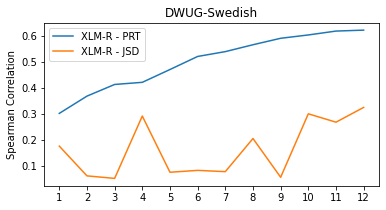

In [175]:
plt.figure(figsize=(6, 3))
plt.plot(list(range(1, 13)), sp_prt, label='XLM-R - PRT')
plt.plot(list(range(1, 13)), sp_jsd, label='XLM-R - JSD')
plt.ylabel('Spearman Correlation')
plt.legend()
plt.title(f'{dataset}')
_ = plt.xticks(list(range(1,13)))